# Section 1: Data Preprocessing and Feature Selection/Extraction (10 points).
Independent of the prediction performance achieved, the jury will reward the research
effort done here. You are expected to:
1. The steps taken to clean and preprocess the data, including tokenization,
lowercasing, and handling any potential duplicates.
2. Explain the motivation and intuition behind each feature. How did you come up
with the feature (e.g., are you following the recommendation of a research
paper)? What is it intended to capture?
3. Rigorously report your experiments about the impact of various combinations of
features on predictive performance, and, depending on the regressor, how you
tackled the task of feature selection.

In [1]:
import os
import re
import time
import gensim.downloader as api
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pandas as pd
import polars as pl

import emot 
import emoji

emot_obj = emot.core.emot() 

In [2]:
# Download some NLP models for processing, optional
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download("punkt")

# Initialize Python porter stemmer
ps = PorterStemmer()

# Initialize Python wordnet lemmatizer
wnl = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/eleves-b/2022/axel.delaval/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /users/eleves-b/2022/axel.delaval/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /users/eleves-b/2022/axel.delaval/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
path_to_data = "../../challenge_data/"

path_to_training_tweets = path_to_data + "train_tweets"
path_to_eval_tweets = path_to_data + "eval_tweets"

### See that `Panda` is slower than `polars`

In [4]:
# Timing pandas concatenation
start_time = time.time()

li = []
for filename in os.listdir(path_to_training_tweets):
    df = pd.read_csv(path_to_training_tweets + "/" + filename)
    li.append(df)
df_pandas = pd.concat(li, ignore_index=True)

pandas_time = time.time() - start_time
print("Pandas Concatenation Time:", pandas_time)
# print(df_pandas)


# Timing polars concatenation
start_time = time.time()

li = []
for filename in os.listdir(path_to_training_tweets):
    df = pl.read_csv(path_to_training_tweets + "/" + filename)
    li.append(df)
df_polars = pl.concat(li)

polars_time = time.time() - start_time
print("Polars Concatenation Time:", polars_time)
# print(df_polars)



Pandas Concatenation Time: 8.172197341918945
Polars Concatenation Time: 0.41210222244262695


In [5]:
def load_data(path):
    li = []
    for filename in os.listdir(path):
        df = pl.read_csv(path + "/" + filename)
        li.append(df)
    return pl.concat(li)

df = load_data(path_to_training_tweets)

print(df.head())
print(f'The shape of the data is: {df.shape}')

shape: (5, 6)
┌─────┬─────────┬──────────┬───────────┬───────────────┬─────────────────────────────────┐
│ ID  ┆ MatchID ┆ PeriodID ┆ EventType ┆ Timestamp     ┆ Tweet                           │
│ --- ┆ ---     ┆ ---      ┆ ---       ┆ ---           ┆ ---                             │
│ str ┆ i64     ┆ i64      ┆ i64       ┆ i64           ┆ str                             │
╞═════╪═════════╪══════════╪═══════════╪═══════════════╪═════════════════════════════════╡
│ 2_0 ┆ 2       ┆ 0        ┆ 0         ┆ 1403538600000 ┆ RT @soccerdotcom: If #ESP beat… │
│ 2_0 ┆ 2       ┆ 0        ┆ 0         ┆ 1403538600000 ┆ Visit the #SITEP official web … │
│ 2_0 ┆ 2       ┆ 0        ┆ 0         ┆ 1403538600000 ┆ RT @soccerdotcom: If #ESP beat… │
│ 2_0 ┆ 2       ┆ 0        ┆ 0         ┆ 1403538600000 ┆ RT @worldsoccershop: If there … │
│ 2_0 ┆ 2       ┆ 0        ┆ 0         ┆ 1403538600000 ┆ RT @soccerdotcom: If #AUS beat… │
└─────┴─────────┴──────────┴───────────┴───────────────┴────────────────────

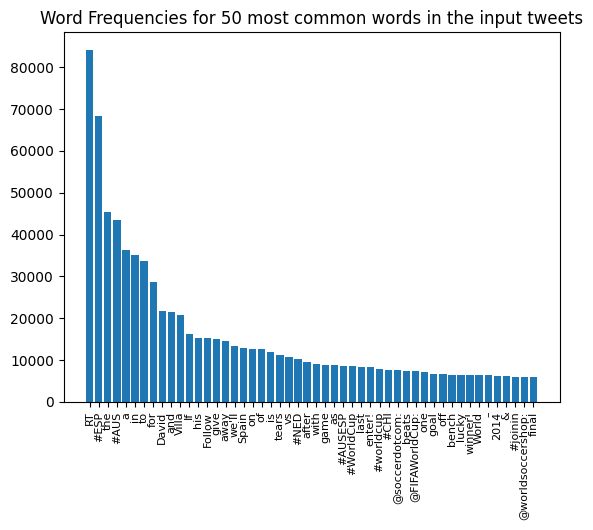

In [6]:
def frequencies(tweets):
    words = np.concatenate([tweet.split() for tweet in tweets])
    unique_words, counts = np.unique(words, return_counts=True)
    return unique_words, counts

def plot_frequencies(tweets, n=50):
    unique_words, counts = frequencies(tweets)
    idx = np.argsort(counts)[::-1][:n]
    plt.bar(unique_words[idx], counts[idx])
    plt.xticks(rotation=90, fontsize=8)
    plt.title(f"Word Frequencies for {n} most common words in the input tweets")
    plt.show()

tweets = np.array(df["Tweet"])
plot_frequencies(tweets[0:100000])

In [7]:
t = time.time()
print(emoji.demojize('Python is 👍, '))
print(time.time() - t)

t = time.time()
print(emot_obj.emoji('Python is 👍'))
print(time.time() - t)

Python is :thumbs_up:, 
0.0031120777130126953
{'value': ['👍'], 'location': [[10, 11]], 'mean': [':thumbs_up:'], 'flag': True}
8.726119995117188e-05


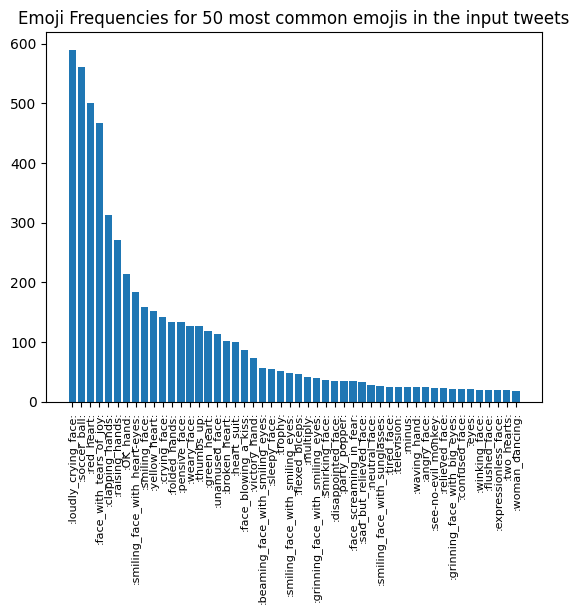

['😭' '⚽' '❤' '😂' '👏' '🙌' '👌' '😍' '☺' '💛' '😢' '🙏' '😔' '😩' '👍' '💚' '😒' '💔'
 '♥' '😘' '✌' '😁' '😪' '🏆' '😊' '💪' '✖' '😄' '😏' '😞' '🎉' '😱' '😥' '😐' '😎' '😫'
 '📺' '➖' '👋' '😠' '🙈' '😌' '😃' '😕' '👀' '😉' '😳' '😑' '💕' '💃']


In [8]:
def extract_emojis(text):
    return [char for char in text if char in emoji.EMOJI_DATA]

def plot_emojis(tweets, n=50):
    emojis = [extract_emojis(tweet) for tweet in tweets]
    emojis = [item for sublist in emojis for item in sublist]
    unique_emojis, counts = np.unique(emojis, return_counts=True)
    idx = np.argsort(counts)[::-1][:n]
    plt.bar([emoji.demojize(u) for u in unique_emojis[idx]], counts[idx])
    plt.xticks(rotation=90, fontsize=8)
    plt.title(f"Emoji Frequencies for {n} most common emojis in the input tweets")
    plt.show()

    print(unique_emojis[idx])

plot_emojis(tweets[0:100000])



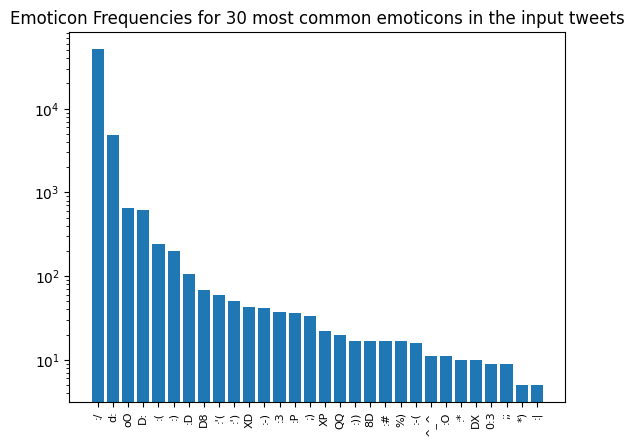

In [9]:
### do the same for emoticons 

def extract_emoticons(text):
    return emot_obj.emoticons(text)

def plot_emoticons(tweets, n=30):
    emoticons = [extract_emoticons(tweet)['value'] for tweet in tweets]
    emoticons = [item for sublist in emoticons for item in sublist]
    unique_emoticons, counts = np.unique(emoticons, return_counts=True)
    idx = np.argsort(counts)[::-1][:n]
    # log scale at y axis
    plt.yscale('log')
    plt.bar(unique_emoticons[idx], counts[idx])
    plt.xticks(rotation=90, fontsize=8)
    plt.title(f"Emoticon Frequencies for {n} most common emoticons in the input tweets")
    plt.show()

plot_emoticons(tweets[0:100000])

In [10]:
def detect_emojis(text):
    emojis = [char for char in text if char in emoji.EMOJI_DATA]
    meanings = [emoji.EMOJI_DATA[char]['en'] for char in emojis]
    return {'value': emojis, 'mean': meanings}

def transform_emojis_to_text(text):
    # emojis = emot_obj.emoji(text)
    emojis = detect_emojis(text)
    text_modified = text
    for i in range(len(emojis['value'])):
        text_modified = text_modified.replace(emojis['value'][i], emojis['mean'][i].replace('_', ' '))
    return text_modified

def transform_emoticons_to_text(text):
    emoticons = emot_obj.emoticons(text)
    text_modified = text 
    for i in range(len(emoticons['value'])):
        text_modified = text_modified.replace(emoticons['value'][i], emoticons['mean'][i])
    return text_modified

print(transform_emojis_to_text('Python is 👍, '))
print(transform_emoticons_to_text('Python is :)'))

Python is :thumbs up:, 
Python is Happy face or smiley


In [ ]:
# Basic preprocessing function
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    print(text)
    # Transform emojis to text
    text = transform_emojis_to_text(text)
    print(text)
    # Transform emoticons to text
    text = transform_emoticons_to_text(text)
    print(text)
    # Lowercasing
    text = text.lower()
    print(text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    print(text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    print(text)
    # Tokenization
    words = text.split()
    print(" ".join(words))
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    print(" ".join(words))
    # Lemmatization
    words = [wnl.lemmatize(word) for word in words]
    print(" ".join(words))
    # Stemming
    words = [ps.stem(word) for word in words]
    print(" ".join(words))
    return ' '.join(words)

# Test de la fonction de prétraitement
text = "I love watching football games! #Sport :) 🏈"
t = time.time()
clean_text = preprocess_text(text)
print(time.time() - t)

I love watching football games! #Sport :) 🏈
I love watching football games! #Sport :) :american football:
I love watching football games! #Sport Happy face or smiley :american football:
i love watching football games! #sport happy face or smiley :american football:
i love watching football games sport happy face or smiley american football
i love watching football games sport happy face or smiley american football
i love watching football games sport happy face or smiley american football
love watching football games sport happy face smiley american football
love watching football game sport happy face smiley american football
love watch footbal game sport happi face smiley american footbal
1.7435731887817383


In [12]:
### Glove import 
# Charger le modèle GloVe (50 dimensions)
embeddings_model = api.load("glove-twitter-50")

In [ ]:
# Basic preprocessing function
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Transform emojis to text
    text = transform_emojis_to_text(text)
    # Transform emoticons to text
    text = transform_emoticons_to_text(text)
    # Lowercasing
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenization
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # # Lemmatization
    # words = [wnl.lemmatize(word) for word in words]
    # Stemming
    words = [ps.stem(word) for word in words]
    return ' '.join(words)

# Function to compute the average word vector for a tweet
def get_avg_embedding(tweet, model, vector_size=50):
    """ 
    Compute the average embedding vector for a tweet
    
    Parameters:
        tweet (str): The tweet text
        model (gensim.models.keyedvectors.Word2VecKeyedVectors): The word embeddings model
        vector_size (int): The size of the word embedding vectors
        
    Returns:
        np.ndarray: The average embedding vector for the tweet
    """

    words = tweet.split()  # Tokenize by whitespace
    word_vectors = [model[word] for word in words if word in model]
    if not word_vectors:  # If no words in the tweet are in the vocabulary, return a zero vector
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

In [14]:
from textblob import TextBlob

para_1 = "I looove waatchin footbal gamess! #Sport :) 🏈"
print(str(TextBlob(para_1).correct()))

I love watching football games! #Port :) 🏈


In [90]:
from spellchecker import SpellChecker

spell = SpellChecker()

def correct_spelling(text):
    words = text.split()
    corrected_words = [spell.correction(word) for word in words]
    return ' '.join(corrected_words)

text = "I looove waatchin footbal gamess! #Sport :) 🏈"

print(correct_spelling(text))

I love watching football games sport i i


In [96]:
from autocorrect import Speller
import re


t = time.time()
spell=Speller(lang="en")
print(spell("I looove waatchin footbal gamess! #Sport :) 🏈"))
print(time.time() - t)

t = time.time()
spell = Speller(lang="en", fast=True)
print(spell("I looove waatchin footbal gamess! #Sport :) 🏈"))
print(time.time() - t)

I love watching football games! #Sport :) 🏈
0.11179733276367188
I looove waatchin football games! #Sport :) 🏈
0.03381490707397461


In [64]:
from joblib import Parallel, delayed
import math
import time

def compute_heavy(x):
    return sum(math.sqrt(i) for i in range(1000))

def test_joblib(nb):
    Parallel(n_jobs=nb)(delayed(compute_heavy)(i) for i in range(100000))

t = time.time()
test_joblib(1)
print("Temps avec 1 job :", time.time() - t)

t = time.time()
test_joblib(10)
print("Temps avec 10 jobs :", time.time() - t)


Temps avec 1 job : 5.112654209136963
Temps avec 10 jobs : 0.7071876525878906


In [ ]:
from joblib import Parallel, delayed

processed_texts = Parallel(n_jobs=4)(
    delayed(preprocess_text)(
        text, 
        with_emojis=True, 
        with_stopwords=False, 
        with_stemming=True
    ) for text in df['Tweet']
)

processed_texts = Parallel(n_jobs=4)(delayed(preprocess_text)(text) for text in df['Tweet'])


In [127]:
text = "I love watching football games! #Sport :) 🏈 #AUS"
list_of_countries_trigrams = ['AFG', 'RSA', 'ALB', 'ALG', 'GER', 'AND', 'ENG', 'ANG', 'AIA', 'ATG', 'KSA', 'ARG', 'ARM', 'ARU', 'AUS', 'AUT', 'AZE', 'BAH', 'BHR', 'BAN', 'BRB', 'BEL', 'BLZ', 'BEN', 'BER', 'BHU', 'BLR', 'MYA', 'BOL', 'BIH', 'BOT', 'BRA', 'BRU', 'BUL', 'BFA', 'BDI', 'CAM', 'CMR', 'CAN', 'CPV', 'CHI', 'CHN', 'CYP', 'COL', 'COM', 'CGO', 'PRK', 'KOR', 'CRC', 'CIV', 'CRO', 'CUB', 'CUR', 'DEN', 'DJI', 'DMA', 'SCO', 'EGY', 'UAE', 'ECU', 'ERI', 'ESP', 'EST', 'ESW', 'USA', 'ETH', 'FIJ', 'FIN', 'FRA', 'GAB', 'GAM', 'GEO', 'GHA', 'GIB', 'GRE', 'GRN', 'GUA', 'GUM', 'GUI', 'EQG', 'GNB', 'GUY', 'HAI', 'HON', 'HKG', 'HUN', 'CAY', 'COK', 'FRO', 'SOL', 'TCA', 'VGB', 'VIR', 'IND', 'IDN', 'IRQ', 'IRN', 'IRL', 'NIR', 'ISL', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KGZ', 'KVX', 'KUW', 'LAO', 'LES', 'LVA', 'LBN', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MKD', 'MAD', 'MAS', 'MWI', 'MDV', 'MLI', 'MLT', 'MAR', 'MRI', 'MTN', 'MEX', 'MDA', 'MNG', 'MNE', 'MSR', 'MOZ', 'NAM', 'NEP', 'NCA', 'NIG', 'NGA', 'NOR', 'NCL', 'NZL', 'OMA', 'UGA', 'UZB', 'PAK', 'PLE', 'PAN', 'PNG', 'PAR', 'NED', 'WAL', 'PER', 'PHI', 'POL', 'PUR', 'POR', 'QAT', 'COD', 'CTA', 'DOM', 'CZE', 'ROU', 'RUS', 'RWA', 'SKN', 'SMR', 'VIN', 'LCA', 'SLV', 'SAM', 'ASA', 'STP', 'SEN', 'SRB', 'SEY', 'SLE', 'SIN', 'SVK', 'SVN', 'SOM', 'SDN', 'SSD', 'SRI', 'SWE', 'SUI', 'SUR', 'SYR', 'TJK', 'TAH', 'TPE', 'TAN', 'CHA', 'THA', 'TLS', 'TOG', 'TGA', 'TRI', 'TUN', 'TKM', 'TUR', 'UKR', 'URU', 'VAN', 'VEN', 'VIE', 'YEM', 'ZAM', 'ZIM', 'BOE', 'GUF', 'GBR', 'GLP', 'NMI', 'KIR', 'MTQ', 'NIU', 'REU', 'SMN', 'SMA', 'TUV', 'ZAN', 'ALA', 'COR', 'GRL', 'GUE', 'IMA', 'FLK', 'MHL', 'JER', 'MYT', 'FSM', 'MCO', 'PLW', 'EUS', 'ESH', 'BLM', 'SPM', 'SHN', 'VAT', 'WLF']
text = re.sub(r'\b(?:' + '|'.join(list_of_countries_trigrams) + r')\b', 'country', text)
print(text)

I love watching football games! #Sport :) 🏈 #country


In [ ]:
from autocorrect import Speller
import re

spell=Speller(lang="en", fast=True)
list_of_countries_trigrams = ['AFG', 'RSA', 'ALB', 'ALG', 'GER', 'AND', 'ENG', 'ANG', 'AIA', 'ATG', 'KSA', 'ARG', 'ARM', 'ARU', 'AUS', 'AUT', 'AZE', 'BAH', 'BHR', 'BAN', 'BRB', 'BEL', 'BLZ', 'BEN', 'BER', 'BHU', 'BLR', 'MYA', 'BOL', 'BIH', 'BOT', 'BRA', 'BRU', 'BUL', 'BFA', 'BDI', 'CAM', 'CMR', 'CAN', 'CPV', 'CHI', 'CHN', 'CYP', 'COL', 'COM', 'CGO', 'PRK', 'KOR', 'CRC', 'CIV', 'CRO', 'CUB', 'CUR', 'DEN', 'DJI', 'DMA', 'SCO', 'EGY', 'UAE', 'ECU', 'ERI', 'ESP', 'EST', 'ESW', 'USA', 'ETH', 'FIJ', 'FIN', 'FRA', 'GAB', 'GAM', 'GEO', 'GHA', 'GIB', 'GRE', 'GRN', 'GUA', 'GUM', 'GUI', 'EQG', 'GNB', 'GUY', 'HAI', 'HON', 'HKG', 'HUN', 'CAY', 'COK', 'FRO', 'SOL', 'TCA', 'VGB', 'VIR', 'IND', 'IDN', 'IRQ', 'IRN', 'IRL', 'NIR', 'ISL', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KGZ', 'KVX', 'KUW', 'LAO', 'LES', 'LVA', 'LBN', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MKD', 'MAD', 'MAS', 'MWI', 'MDV', 'MLI', 'MLT', 'MAR', 'MRI', 'MTN', 'MEX', 'MDA', 'MNG', 'MNE', 'MSR', 'MOZ', 'NAM', 'NEP', 'NCA', 'NIG', 'NGA', 'NOR', 'NCL', 'NZL', 'OMA', 'UGA', 'UZB', 'PAK', 'PLE', 'PAN', 'PNG', 'PAR', 'NED', 'WAL', 'PER', 'PHI', 'POL', 'PUR', 'POR', 'QAT', 'COD', 'CTA', 'DOM', 'CZE', 'ROU', 'RUS', 'RWA', 'SKN', 'SMR', 'VIN', 'LCA', 'SLV', 'SAM', 'ASA', 'STP', 'SEN', 'SRB', 'SEY', 'SLE', 'SIN', 'SVK', 'SVN', 'SOM', 'SDN', 'SSD', 'SRI', 'SWE', 'SUI', 'SUR', 'SYR', 'TJK', 'TAH', 'TPE', 'TAN', 'CHA', 'THA', 'TLS', 'TOG', 'TGA', 'TRI', 'TUN', 'TKM', 'TUR', 'UKR', 'URU', 'VAN', 'VEN', 'VIE', 'YEM', 'ZAM', 'ZIM', 'BOE', 'GUF', 'GBR', 'GLP', 'NMI', 'KIR', 'MTQ', 'NIU', 'REU', 'SMN', 'SMA', 'TUV', 'ZAN', 'ALA', 'COR', 'GRL', 'GUE', 'IMA', 'FLK', 'MHL', 'JER', 'MYT', 'FSM', 'MCO', 'PLW', 'EUS', 'ESH', 'BLM', 'SPM', 'SHN', 'VAT', 'WLF']

# Basic preprocessing function
def preprocess_text(text, 
                    nb_it, 
                    nb_max_it, 
                    with_URLs=True,
                    with_emojis=True,
                    with_emoticons=True,
                    with_lowercasing=True,
                    with_punctuation=True,
                    with_numbers=True,
                    with_stemming=True, 
                    with_lemmatization=True, 
                    with_stopwords=True,
                    with_trigrams=True,
                    with_spelling_correction=True):
    if nb_it % (nb_max_it//100) == 0: 
        print(f"Processing text {nb_it} / {nb_max_it} ({nb_it/nb_max_it*100:.2f}%)")
    if with_URLs:
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
    if with_trigrams:
        # if a word in the text is a country trigram, we replace it by 'country'
        text = re.sub(r'\b(?:' + '|'.join(list_of_countries_trigrams) + r')\b', 'country', text)
    if with_spelling_correction:
        # Correct spelling
        text = spell(text)
    if with_emojis:
        # Transform emojis to text
        text = transform_emojis_to_text(text)
    if with_emoticons:
        # Transform emoticons to text
        text = transform_emoticons_to_text(text)
    if with_lowercasing:
        # Lowercasing
        text = text.lower()
    if with_punctuation:
        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)
    if with_numbers:
        # Remove numbers
        text = re.sub(r'\d+', '', text)

    # Tokenization
    words = text.split()
    if with_stopwords:
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
    if with_lemmatization:
        # Lemmatization
        words = [wnl.lemmatize(word) for word in words]
    if with_stemming:
        # Stemming
        words = [ps.stem(word) for word in words]
    return ' '.join(words)

# Function to compute the average word vector for a tweet
def get_avg_embedding(tweet, model, vector_size=50):
    """ 
    Compute the average embedding vector for a tweet
    
    Parameters:
        tweet (str): The tweet text
        model (gensim.models.keyedvectors.Word2VecKeyedVectors): The word embeddings model
        vector_size (int): The size of the word embedding vectors
        
    Returns:
        np.ndarray: The average embedding vector for the tweet
    """

    words = tweet.split()  # Tokenize by whitespace
    word_vectors = [model[word] for word in words if word in model]
    if not word_vectors:  # If no words in the tweet are in the vocabulary, return a zero vector
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

def compute_accuracy(path_to_training_tweets, 
                        keep_only=100000,
                        with_URLs=True,
                        with_emojis=True,
                        with_emoticons=True,
                        with_lowercasing=True,
                        with_punctuation=True,
                        with_numbers=True,
                        with_stemming=True, 
                        with_lemmatization=False, 
                        with_stopwords=True, 
                        with_trigrams=True,
                        with_spelling_correction=True):
    # Load the data
    df = load_data(path_to_training_tweets)

    # Keep only the first tweets
    df = df.head(keep_only)

    # Apply preprocessing to each tweet
    tweets_preprocessed = [preprocess_text(tweet, i, len(df["Tweet"]), with_emojis=with_emojis,
                                            with_URLs=with_URLs,
                                            with_emoticons=with_emoticons,
                                            with_lowercasing=with_lowercasing,
                                            with_punctuation=with_punctuation,
                                            with_numbers=with_numbers,
                                            with_stemming=with_stemming,
                                            with_lemmatization=with_lemmatization,
                                            with_stopwords=with_stopwords,
                                            with_trigrams= with_trigrams,
                                            with_spelling_correction=with_spelling_correction) for i, tweet in enumerate(df["Tweet"].to_list())]

    # Replace the 'Tweet' column with the preprocessed tweets
    df = df.with_columns(pl.Series("Tweet", tweets_preprocessed))

    # Apply preprocessing to each tweet and obtain vectors
    vector_size = 50
    tweet_vectors = np.vstack([
        get_avg_embedding(tweet, embeddings_model, vector_size) for tweet in df["Tweet"].to_list()
    ])

    # Create a DataFrame from tweet vectors
    tweet_df = pl.DataFrame(tweet_vectors)

    # Attach the vectors to the original dataframe
    period_features = pl.concat([df, tweet_df], how="horizontal")

    # Drop the columns that are not useful anymore
    period_features = period_features.drop(["Timestamp", "Tweet"])

    # Group the tweets into their corresponding periods and calculate the mean
    period_features = (
        period_features.group_by(["MatchID", "PeriodID", "ID"])
        .agg(pl.all().mean())
    )


    # Drop non-numerical features and keep embedding values
    X = period_features.drop(["EventType", "MatchID", "PeriodID", "ID"]).to_numpy()
    # Extract labels
    y = period_features["EventType"].to_numpy()

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train a logistic regression classifier
    clf = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)


In [130]:
print("replacing smileys and emojis by meaning, and stemming : ", compute_accuracy(path_to_training_tweets, keep_only=100000, with_spelling_correction=True, with_trigrams=False))

Processing text 0 / 100000 (0.00%)
Processing text 1000 / 100000 (1.00%)
Processing text 2000 / 100000 (2.00%)
Processing text 3000 / 100000 (3.00%)
Processing text 4000 / 100000 (4.00%)
Processing text 5000 / 100000 (5.00%)
Processing text 6000 / 100000 (6.00%)
Processing text 7000 / 100000 (7.00%)
Processing text 8000 / 100000 (8.00%)
Processing text 9000 / 100000 (9.00%)
Processing text 10000 / 100000 (10.00%)
Processing text 11000 / 100000 (11.00%)
Processing text 12000 / 100000 (12.00%)
Processing text 13000 / 100000 (13.00%)
Processing text 14000 / 100000 (14.00%)
Processing text 15000 / 100000 (15.00%)
Processing text 16000 / 100000 (16.00%)
Processing text 17000 / 100000 (17.00%)
Processing text 18000 / 100000 (18.00%)
Processing text 19000 / 100000 (19.00%)
Processing text 20000 / 100000 (20.00%)
Processing text 21000 / 100000 (21.00%)
Processing text 22000 / 100000 (22.00%)
Processing text 23000 / 100000 (23.00%)
Processing text 24000 / 100000 (24.00%)
Processing text 25000 /

In [ ]:
print("replacing smileys and emojis by meaning, and stemming : ", compute_accuracy(path_to_training_tweets, keep_only=100000, with_spelling_correction=False, with_trigrams=False))

Processing text 0 / 100000 (0.00%)
Processing text 1000 / 100000 (1.00%)
Processing text 2000 / 100000 (2.00%)
Processing text 3000 / 100000 (3.00%)
Processing text 4000 / 100000 (4.00%)
Processing text 5000 / 100000 (5.00%)
Processing text 6000 / 100000 (6.00%)
Processing text 7000 / 100000 (7.00%)
Processing text 8000 / 100000 (8.00%)
Processing text 9000 / 100000 (9.00%)
Processing text 10000 / 100000 (10.00%)
Processing text 11000 / 100000 (11.00%)
Processing text 12000 / 100000 (12.00%)
Processing text 13000 / 100000 (13.00%)
Processing text 14000 / 100000 (14.00%)
Processing text 15000 / 100000 (15.00%)
Processing text 16000 / 100000 (16.00%)
Processing text 17000 / 100000 (17.00%)
Processing text 18000 / 100000 (18.00%)
Processing text 19000 / 100000 (19.00%)
Processing text 20000 / 100000 (20.00%)
Processing text 21000 / 100000 (21.00%)
Processing text 22000 / 100000 (22.00%)
Processing text 23000 / 100000 (23.00%)
Processing text 24000 / 100000 (24.00%)
Processing text 25000 /

In [ ]:
print("replacing smileys and emojis by meaning, and stemming : ", compute_accuracy(path_to_training_tweets, keep_only=100000, with_spelling_correction=False, with_emojis=False, with_emoticons=False, with_trigrams=False))

Processing text 0 / 100000 (0.00%)
Processing text 1000 / 100000 (1.00%)
Processing text 2000 / 100000 (2.00%)
Processing text 3000 / 100000 (3.00%)
Processing text 4000 / 100000 (4.00%)
Processing text 5000 / 100000 (5.00%)
Processing text 6000 / 100000 (6.00%)
Processing text 7000 / 100000 (7.00%)
Processing text 8000 / 100000 (8.00%)
Processing text 9000 / 100000 (9.00%)
Processing text 10000 / 100000 (10.00%)
Processing text 11000 / 100000 (11.00%)
Processing text 12000 / 100000 (12.00%)
Processing text 13000 / 100000 (13.00%)
Processing text 14000 / 100000 (14.00%)
Processing text 15000 / 100000 (15.00%)
Processing text 16000 / 100000 (16.00%)
Processing text 17000 / 100000 (17.00%)
Processing text 18000 / 100000 (18.00%)
Processing text 19000 / 100000 (19.00%)
Processing text 20000 / 100000 (20.00%)
Processing text 21000 / 100000 (21.00%)
Processing text 22000 / 100000 (22.00%)
Processing text 23000 / 100000 (23.00%)
Processing text 24000 / 100000 (24.00%)
Processing text 25000 /

In [131]:
print("replacing smileys and emojis by meaning, and stemming : ", compute_accuracy(path_to_training_tweets, keep_only=100000, with_spelling_correction=False, with_emojis=False, with_emoticons=False, with_trigrams=True))

Processing text 0 / 100000 (0.00%)
Processing text 1000 / 100000 (1.00%)
Processing text 2000 / 100000 (2.00%)
Processing text 3000 / 100000 (3.00%)
Processing text 4000 / 100000 (4.00%)
Processing text 5000 / 100000 (5.00%)
Processing text 6000 / 100000 (6.00%)
Processing text 7000 / 100000 (7.00%)
Processing text 8000 / 100000 (8.00%)
Processing text 9000 / 100000 (9.00%)
Processing text 10000 / 100000 (10.00%)
Processing text 11000 / 100000 (11.00%)
Processing text 12000 / 100000 (12.00%)
Processing text 13000 / 100000 (13.00%)
Processing text 14000 / 100000 (14.00%)
Processing text 15000 / 100000 (15.00%)
Processing text 16000 / 100000 (16.00%)
Processing text 17000 / 100000 (17.00%)
Processing text 18000 / 100000 (18.00%)
Processing text 19000 / 100000 (19.00%)
Processing text 20000 / 100000 (20.00%)
Processing text 21000 / 100000 (21.00%)
Processing text 22000 / 100000 (22.00%)
Processing text 23000 / 100000 (23.00%)
Processing text 24000 / 100000 (24.00%)
Processing text 25000 /

In [ ]:
import polars as pl

print(pl.__version__)


1.13.1
